 # Analyzing Grassland Cover with ortho-imagery

 This notebook demonstrates how to perfomr a stratify sampling and do binary validation (grassland vs non-grassland) of the EUGW rasters based on visualizing orthoimagery within a specified area of interest.

 **Inputs:**
 - `grassland_raster_path`: Path to your grassland cover raster layer.
 - `sac_shapefile_path`: Path to your SAC (habitat types) polygon shapefile.
 - `wms_url`: WMS URL for orthoimages.



## 1. Setup and Library Imports

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask
import rasterio.plot
from shapely.geometry import box, mapping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from owslib.wms import WebMapService
from IPython.display import Image, display, clear_output
import io
import random # For random selection
import math # Import math for rounding

#import leafmap.leafmap as leafmap  # Use .leaflet if running in JupyterLab
import leafmap.foliumap as leafmap
from folium import Icon
import tempfile
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

/home/zbub/anaconda3/envs/eugw/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 2. Define File Paths and Hyperparameters

In [2]:
# --- USER INPUT REQUIRED ---
# Replace with the actual paths to your files (upload your the EU Grasland watch rasters from your study area)
grassland_raster_path1_2023 = '/home/zbub/AOPK/EUGW_round2/Milovice_Mlada/EUGW_data/CZ_CON_CON_75111_20230101_20231231_GTYH_CLASS.tif'  


# Your WMS URL
wms_url1 = 'https://geoportal.cuzk.cz/WMS_ORTOFOTO_PUB/WMService.aspx' 


# Upload a polygon of your study area (e.g. SAC area)
sac_shapefile_path = '/home/zbub/AOPK/EUGW_round2/data/evl_MM.gpkg'             

# Export paths for your created grids and sampled grids
output_path_locations = "/home/zbub/AOPK/EUGW_round2/ortho_validation/Milovice_Mlada/combined_raster_points_2023.gpkg"
output_path_sampled_locations= '/home/zbub/AOPK/EUGW_round2/ortho_validation/Milovice_Mlada/labeled_random_points_2023.gpkg'

# your local crs
crs_local = "EPSG:3035"

# Path to save incremental progress
progress_save_path = "user_labels_progress.csv"

# --- END USER INPUT ---


# --- DEFAULT SETTINGS (no need to change) ---
# Hyperparameters
num_of_total_random_cells_to_sample = 400 # Total number of random grid cells to select for evaluation
random_seed = 42 # For reproducibility

plot_legend_of_EU_grassland_watch = False # do you want to visualize the legend of the grassland rasters? If not, you get a binary raster legend/image.

# Sampling strategy
Sampling_region = "SAC" 

#sampling = 'random' # complete random sampling (of num_random_grids)
sampling = 'binary_stratified_random' # uncommend this line if you want to use stratified random sampling for the strata 'Grassland' and 'Non-Grassland'. 


allocation = 'equal' # for stratified random sampling with equal allocation of the strata (so all the strata have the same number of samples).
#allocation = 'proportional' # for stratified random sampling with proportional allocation of the strata (so the number of samples is proportional to the area of the strata).


# Set random seed
random.seed(random_seed)
np.random.seed(random_seed)
# --- END DEFAULT SETTINGS ---

## 3. Load SAC Shapefile and Define Extent

In [3]:
try:
    sac = gpd.read_file(sac_shapefile_path)
    print(f"SAC shapefile loaded successfully. CRS: {sac.crs}")
except Exception as e:
    print(f"Error loading SAC shapefile: {e}")
    print("Please ensure the 'sac_shapefile_path' is correct and the file exists.")
    exit()



SAC shapefile loaded successfully. CRS: EPSG:3035


In [4]:
from owslib.wms import WebMapService
wms1 = WebMapService(wms_url1)
print("WMS Layers:")

for name1 in wms1.contents:
    print(f"- {name1}: {wms1[name1].title}")
    print(name1)


WMS Layers:
- GR_ORTFOTORGB: Ortofoto
GR_ORTFOTORGB


In [5]:
# Visualize
from owslib.wms import WebMapService
wms1 = WebMapService(wms_url1)
print("WMS Layers:")




for name1 in wms1.contents:
    print(f"- {name1}: {wms1[name1].title}")
    print(name1)

#################################################################################################
# - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #

# USER INPUT

# The layer name
layer_name = 'GR_ORTFOTORGB'

# - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
#################################################################################################

# A title for your WMS layer on the map
layer_title1 = wms1[layer_name].title # Aapassing --> name2 --> layer_name




# Reproject grid geometry to EPSG:4326 for proper map display
sac_geom_4326 = sac.to_crs(epsg=4326)
# Get total bounding box of all geometries
minx, miny, maxx, maxy = sac_geom_4326.total_bounds

# Optionally: Get center of bounding box
center_latlon = ((miny + maxy) / 2, (minx + maxx) / 2)
# Get centroid in lat/lon
center_latlon2 = (sac_geom_4326.centroid.y, sac_geom_4326.centroid.x)


# Create a leafmap
m = leafmap.Map(center=(center_latlon[0], center_latlon[1]), zoom=15) # Centered roughly on Wallonia

# Add the WMS layer
# The 'format' and 'transparent' parameters are common for WMS
# You might need to adjust 'crs' if the default (EPSG:4326) doesn't work well,
# but for visualization, EPSG:4326 is usually a good starting point.
m.add_wms_layer(
    url=wms_url1,
    layers=layer_name,
    name=layer_title1,
    format='image/png',
    transparent=True,
    
    #crs={'crs': 'EPSG:3857', 'uppercase': True} # Uncomment and try other CRS if the default doesn't work well
)

# Convert all datetime columns to string (ISO format)
for col in sac_geom_4326.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]', 'object']):
    if sac_geom_4326[col].apply(lambda x: isinstance(x, pd.Timestamp)).any():
        sac_geom_4326[col] = sac_geom_4326[col].astype(str)

m.add_gdf(sac_geom_4326, layer_name="SAC Geometry",
          style={'color': 'blue', 'weight': 2, 'fillOpacity': 0.1},)
#crs = {'crs': 'EPSG:3857'}
#crs = {'srs': 'EPSG:3857'}

#crs={'init': 'EPSG:3857', 'name': 'EPSG:3857'}
#crs={'crs': 'EPSG:3857', 'uppercase': True}


# Define raster colormap and labels
if plot_legend_of_EU_grassland_watch == True:
    raster_legend_data = {
        20: {'label': 'No data due to clipping or no grassland', 'color': 'gray'},
        21: {'label': 'GT1 - Dry grassland', 'color': 'orange'},
        22: {'label': 'GT2 - Mesic grassland', 'color': 'green'},
        23: {'label': 'GT3 - Wet and seasonally wet grassland', 'color': 'blue'},
        24: {'label': 'GT4 - Alpine and sub-alpine grassland', 'color': 'purple'},
        25: {'label': 'GT5 - Forest clearings', 'color': 'darkgreen'},
        26: {'label': 'GT6 - Inland salt steppes', 'color': 'red'},
        27: {'label': 'GT7 - Sparsely wooded grassland', 'color': 'brown'}
        }
else: 
    raster_legend_data = {
        0: {'label': 'Non-grassland or No data', 'color': 'gray'},
        21: {'label': 'Grassland', 'color': 'green'}  # Anything > 20
        }

    # For binary representation, values above 20 will be mapped to 21 (grassland), rest to 0
    def simplify_raster(raster_array):
        simplified = np.where(raster_array > 20, 21, 0)
        return simplified
            


# Create colormap for m.add_raster
sorted_values = sorted(raster_legend_data.keys())
colors_for_cmap = [raster_legend_data[val]['color'] for val in sorted_values]
cmap = mcolors.ListedColormap(colors_for_cmap)
# Define boundaries for BoundaryNorm.
# For N discrete values, we need N+1 boundaries.
# Each value `v` will be mapped to the color corresponding to the bin `[v, v+1)`.
# So, for values [21, 22, ..., 27], the boundaries will be [21, 22, ..., 27, 28].
bounds = np.array(sorted_values + [max(sorted_values) + 1]) # Add one more boundary point

# Create the normalization. The number of colors (cmap.N) must match the number of bins (len(bounds) - 1).
norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
# Add raster overlays (safely clipped if intersecting)
def add_EUGW_raster(raster_path, label, custom_cmap, custom_norm):
    try:
        with rasterio.open(raster_path) as src:


            out_image = src.read(1)

            out_meta = src.meta.copy()
            out_meta.update({
                "nodata": src.nodata if src.nodata is not None else 0 # Use raster's nodata or default to 0
            })

            if out_meta["nodata"] is not None:
                out_image[out_image == out_meta["nodata"]] = 0
                    
            if not plot_legend_of_EU_grassland_watch:
                out_image = simplify_raster(out_image)
            
            out_image[out_image == 0] = out_meta["nodata"]    

            with tempfile.NamedTemporaryFile(delete=False, suffix=".tif") as tmp:
                with rasterio.open(tmp.name, "w", **out_meta) as dst:
                    dst.write(out_image[np.newaxis, :, :])  # Adds the band dimension
                m.add_raster(tmp.name, layer_name=label, colormap=custom_cmap, vmin=min(sorted_values), vmax=max(sorted_values), nodata=out_meta["nodata"])

    except Exception as e:
        print(f"An error occurred while adding {label}: {e}")



# Add both rasters if possible
add_EUGW_raster(grassland_raster_path1_2023, "Grassland Raster 1", cmap, norm)


# Add custom legend for the raster layers
legend_keys = {}
for val in sorted_values:
    data = raster_legend_data[val]
    legend_keys[data['label']] = data['color']

            
m.add_legend(title="Grassland Types", legend_dict=legend_keys)

m.zoom_to_bounds([minx, miny, maxx, maxy])

# Display the map (this will open in your browser or show in a Jupyter Notebook)
display(m)

# Save a copy you can always open in your browser
m.to_html("overview_map_study_area.html")
print("✅ Map saved to overview_map_study_area.html")

WMS Layers:
- GR_ORTFOTORGB: Ortofoto
GR_ORTFOTORGB


✅ Map saved to overview_map_study_area.html


Exception possibly due to cache backend.
Traceback (most recent call last):
  File "/home/zbub/anaconda3/envs/eugw/lib/python3.13/site-packages/flask_caching/__init__.py", line 435, in decorated_function
    self.cache.set(
    ~~~~~~~~~~~~~~^
        cache_key,
        ^^^^^^^^^^
        rv,
        ^^^
        timeout=cache_timeout,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/zbub/anaconda3/envs/eugw/lib/python3.13/site-packages/cachelib/simple.py", line 75, in set
    self._prune()
    ~~~~~~~~~~~^^
  File "/home/zbub/anaconda3/envs/eugw/lib/python3.13/site-packages/cachelib/simple.py", line 52, in _prune
    self._remove_expired(now)
    ~~~~~~~~~~~~~~~~~~~~^^^^^
  File "/home/zbub/anaconda3/envs/eugw/lib/python3.13/site-packages/cachelib/simple.py", line 36, in _remove_expired
    toremove = [k for k, (expires, _) in self._cache.items() if expires < now]
                                         ~~~~~~~~~~~~~~~~~^^
RuntimeError: dictionary keys changed during iteration

## 4. Create sampling grid

In [6]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
import pandas as pd
import os

# Raster paths
raster_paths = {
    "raster1": grassland_raster_path1_2023,
}

# Define raster simplification function (if binary legend selected)
def simplify_raster(raster_array):
    return np.where(raster_array > 20, 21, 0)

# Function to extract center coordinates of valid raster cells
def extract_valid_points(raster_path, raster_id, simplify=False):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform
        data_meta = src.meta.copy()
        data_meta.update({
            "nodata": src.nodata if src.nodata is not None else 0 # Use raster's nodata or default to 0
        })

        if data_meta["nodata"] is not None:
            data[data == data_meta["nodata"]] = 0

        # Apply simplification if needed
        if simplify:
            data = simplify_raster(data)

        # Mask nodata values
        valid_mask = data >= 0
        valid_rows, valid_cols = np.where(valid_mask)
        valid_values = data[valid_mask]

        # Convert pixel indices to coordinates (cell centers)
        xs, ys = rasterio.transform.xy(transform, valid_rows, valid_cols, offset='center')

        # Create GeoDataFrame
        df = pd.DataFrame({
            'raster_id': raster_id,
            'value': valid_values,
            'x': xs,
            'y': ys,
        })

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs=src.crs)
        return gdf
    

# Combine all rasters
all_points = []

for raster_id, path in raster_paths.items():
    gdf = extract_valid_points(path, raster_id, simplify=True)
    if Sampling_region == "SAC":
        if isinstance(sac, gpd.GeoDataFrame):
            # spatial join: keep only points within sac polygons
            gdf = gpd.sjoin(gdf, sac, predicate="within")
            gdf = gdf.drop(columns=sac.columns.difference(["geometry"]), errors="ignore")
        else:
            # assume sac is a shapely Polygon/MultiPolygon
            gdf = gdf[gdf.geometry.within(sac)]
    
    all_points.append(gdf)



combined_points_gdf = pd.concat(all_points, ignore_index=True)

# Optional: save to disk
#output_points_path = output_path_locations
#combined_points_gdf.to_file(output_points_path, driver="GPKG")

#print(f"Saved {len(combined_points_gdf)} points to: {output_points_path}")


In [7]:
# Optional: if alreayd saved, load from disk  
#combined_points_gdf = gpd.read_file(output_path_locations)

combined_points_gdf

,raster_id,value,x,y,geometry,index_right
0,raster1,0,4668465.0,3032985.0,POINT (4668465 3032985),0
1,raster1,0,4668465.0,3032975.0,POINT (4668465 3032975),0
2,raster1,0,4668475.0,3032975.0,POINT (4668475 3032975),0
3,raster1,0,4668485.0,3032975.0,POINT (4668485 3032975),0
4,raster1,0,4668495.0,3032975.0,POINT (4668495 3032975),0
...,...,...,...,...,...,...
124442,raster1,21,4668965.0,3025335.0,POINT (4668965 3025335),0
124443,raster1,21,4668975.0,3025335.0,POINT (4668975 3025335),0
124444,raster1,21,4668985.0,3025335.0,POINT (4668985 3025335),0
124445,raster1,21,4668995.0,3025335.0,POINT (4668995 3025335),0


In [8]:
combined_points_gdf['value']

0          0
1          0
2          0
3          0
4          0
          ..
124442    21
124443    21
124444    21
124445    21
124446    21
Name: value, Length: 124447, dtype: int64

In [9]:
def random_sampling(gdf, n_samples, seed=42):
    return gdf.sample(n=n_samples, random_state=seed)

def stratified_sampling(gdf, total_samples, strategy='equal', seed=42):
    np.random.seed(seed)
    strata = gdf['value'].unique()
    
    sampled_dfs = []

    if strategy == 'equal':
        samples_per_stratum = total_samples // len(strata)
        for val in strata:
            subset = gdf[gdf['value'] == val]
            sampled = subset.sample(n=min(samples_per_stratum, len(subset)), random_state=seed)
            sampled_dfs.append(sampled)

    elif strategy == 'proportional':
        total_count = len(gdf)
        for val in strata:
            subset = gdf[gdf['value'] == val]
            proportion = len(subset) / total_count
            n_samples = max(1, int(round(proportion * total_samples)))
            sampled = subset.sample(n=min(n_samples, len(subset)), random_state=seed)
            sampled_dfs.append(sampled)

    else:
        raise ValueError("Invalid strategy. Use 'equal' or 'proportional'.")

    return pd.concat(sampled_dfs, ignore_index=True)

if sampling == 'random':
    sampled_points_gdf = random_sampling(combined_points_gdf, num_of_total_random_cells_to_sample, seed=random_seed)
elif sampling == 'binary_stratified_random':
    sampled_points_gdf = stratified_sampling(combined_points_gdf, num_of_total_random_cells_to_sample, strategy=allocation, seed=random_seed)
else: print("Invalid sampling strategy. Please choose 'random' or 'binary_stratified_random'.")
    


In [10]:
sampled_points_gdf

,raster_id,value,x,y,geometry,index_right
0,raster1,0,4670005.0,3026925.0,POINT (4670005 3026925),0
1,raster1,0,4669365.0,3027735.0,POINT (4669365 3027735),0
2,raster1,0,4669875.0,3026495.0,POINT (4669875 3026495),0
3,raster1,0,4668425.0,3030885.0,POINT (4668425 3030885),0
4,raster1,0,4669695.0,3029885.0,POINT (4669695 3029885),0
...,...,...,...,...,...,...
395,raster1,21,4669695.0,3027355.0,POINT (4669695 3027355),0
396,raster1,21,4668335.0,3030435.0,POINT (4668335 3030435),0
397,raster1,21,4667965.0,3030325.0,POINT (4667965 3030325),0
398,raster1,21,4669815.0,3027585.0,POINT (4669815 3027585),0


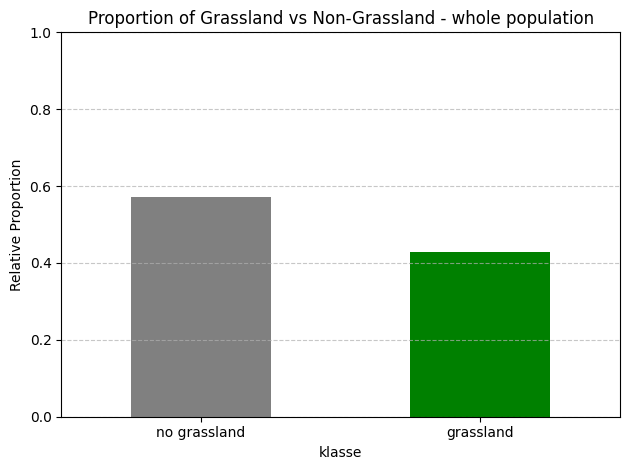

klasse
no grassland    0.570813
grassland       0.429187
Name: proportion, dtype: float64


In [11]:
# Map values to labels
klasse_order = ["no grassland", "grassland"]
klasse_map = {0: "no grassland", 21: "grassland"}
combined_points_gdf['klasse'] = combined_points_gdf['value'].map(klasse_map)

# Compute relative proportions
proportions = combined_points_gdf['klasse'].value_counts(normalize=True).reindex(klasse_order, fill_value=0)

# Plot
proportions.plot(kind='bar', color=['gray', 'green'])
plt.ylabel("Relative Proportion")
plt.title("Proportion of Grassland vs Non-Grassland - whole population")
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Since proportions range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(proportions)


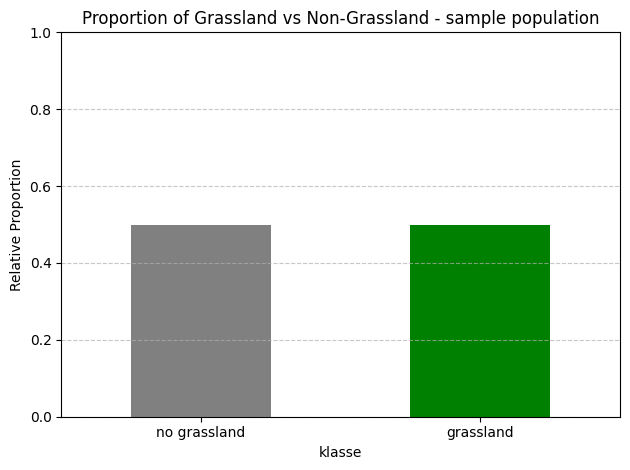

klasse
no grassland    0.5
grassland       0.5
Name: proportion, dtype: float64


In [12]:
# Map values to labels
sampled_points_gdf['klasse'] = sampled_points_gdf['value'].map(klasse_map)

# Compute relative proportions
proportions2 = sampled_points_gdf['klasse'].value_counts(normalize=True).reindex(klasse_order, fill_value=0)

# Plot
proportions2.plot(kind='bar', color=['gray', 'green'])
plt.ylabel("Relative Proportion")
plt.title("Proportion of Grassland vs Non-Grassland - sample population")
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Since proportions range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(proportions2)


In [13]:
sampled_points_gdf = sampled_points_gdf.reset_index()

# Rename the new column if needed
sampled_points_gdf.rename(columns={'fid': 'row_name'}, inplace=True)

sampled_points_gdf



,index,raster_id,value,x,y,geometry,index_right,klasse
0,0,raster1,0,4670005.0,3026925.0,POINT (4670005 3026925),0,no grassland
1,1,raster1,0,4669365.0,3027735.0,POINT (4669365 3027735),0,no grassland
2,2,raster1,0,4669875.0,3026495.0,POINT (4669875 3026495),0,no grassland
3,3,raster1,0,4668425.0,3030885.0,POINT (4668425 3030885),0,no grassland
4,4,raster1,0,4669695.0,3029885.0,POINT (4669695 3029885),0,no grassland
...,...,...,...,...,...,...,...,...
395,395,raster1,21,4669695.0,3027355.0,POINT (4669695 3027355),0,grassland
396,396,raster1,21,4668335.0,3030435.0,POINT (4668335 3030435),0,grassland
397,397,raster1,21,4667965.0,3030325.0,POINT (4667965 3030325),0,grassland
398,398,raster1,21,4669815.0,3027585.0,POINT (4669815 3027585),0,grassland


In [14]:
# Visualize
from owslib.wms import WebMapService
wms1 = WebMapService(wms_url1)
print("WMS Layers:")

for name1 in wms1.contents:
    print(f"- {name1}: {wms1[name1].title}")
    print(name1)


# The layer name (from your output, it's '0')
layer_name = 'GR_ORTFOTORGB'

# A title for your WMS layer on the map
layer_title1 = wms1[name1].title # Aanpassing -->  layer_name!!!!!!!!!!!!!!!!!!!!!!!!!


# Reproject grid geometry to EPSG:4326 for proper map display
sac_geom_4326 = sac.to_crs(epsg=4326)
# Get total bounding box of all geometries
minx, miny, maxx, maxy = sac_geom_4326.total_bounds

# Optionally: Get center of bounding box
center_latlon = ((miny + maxy) / 2, (minx + maxx) / 2)

# Get centroid in lat/lon
center_latlon2 = (sac_geom_4326.centroid.y, sac_geom_4326.centroid.x)


# Create a leafmap
m = leafmap.Map(center=(center_latlon[0], center_latlon[1]), zoom=15) # Centered roughly on Wallonia

# Add the WMS layer
# The 'format' and 'transparent' parameters are common for WMS
# You might need to adjust 'crs' if the default (EPSG:4326) doesn't work well,
# but for visualization, EPSG:4326 is usually a good starting point.
m.add_wms_layer(
    url=wms_url1,
    layers=layer_name,
    name=layer_title1,
    format='image/png',
    transparent=True,
    
    #crs={'crs': 'EPSG:3857', 'uppercase': True} # Uncomment and try other CRS if the default doesn't work well
)


# Convert all datetime columns to string (ISO format)
for col in sac_geom_4326.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]', 'object']):
    if sac_geom_4326[col].apply(lambda x: isinstance(x, pd.Timestamp)).any():
        sac_geom_4326[col] = sac_geom_4326[col].astype(str)

m.add_gdf(sac_geom_4326, layer_name="SAC Geometry",
          style={'color': 'blue', 'weight': 2, 'fillOpacity': 0.1},)
#crs = {'crs': 'EPSG:3857'}
#crs = {'srs': 'EPSG:3857'}

#crs={'init': 'EPSG:3857', 'name': 'EPSG:3857'}
#crs={'crs': 'EPSG:3857', 'uppercase': True}


# Define raster colormap and labels
if plot_legend_of_EU_grassland_watch == True:
    raster_legend_data = {
        20: {'label': 'No data due to clipping or no grassland', 'color': 'gray'},
        21: {'label': 'GT1 - Dry grassland', 'color': 'orange'},
        22: {'label': 'GT2 - Mesic grassland', 'color': 'green'},
        23: {'label': 'GT3 - Wet and seasonally wet grassland', 'color': 'blue'},
        24: {'label': 'GT4 - Alpine and sub-alpine grassland', 'color': 'purple'},
        25: {'label': 'GT5 - Forest clearings', 'color': 'darkgreen'},
        26: {'label': 'GT6 - Inland salt steppes', 'color': 'red'},
        27: {'label': 'GT7 - Sparsely wooded grassland', 'color': 'brown'}
        }
else: 
    raster_legend_data = {
        0: {'label': 'Non-grassland or No data', 'color': 'gray'},
        21: {'label': 'Grassland', 'color': 'green'}  # Anything > 20
        }

    # For binary representation, values above 20 will be mapped to 21 (grassland), rest to 0
    def simplify_raster(raster_array):
        simplified = np.where(raster_array > 20, 21, 0)
        return simplified
            


# Create colormap for m.add_raster
sorted_values = sorted(raster_legend_data.keys())
colors_for_cmap = [raster_legend_data[val]['color'] for val in sorted_values]
cmap = mcolors.ListedColormap(colors_for_cmap)
# Define boundaries for BoundaryNorm.
# For N discrete values, we need N+1 boundaries.
# Each value `v` will be mapped to the color corresponding to the bin `[v, v+1)`.
# So, for values [21, 22, ..., 27], the boundaries will be [21, 22, ..., 27, 28].
bounds = np.array(sorted_values + [max(sorted_values) + 1]) # Add one more boundary point

# Create the normalization. The number of colors (cmap.N) must match the number of bins (len(bounds) - 1).
norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
# Add raster overlays (safely clipped if intersecting)
def add_EUGW_raster(raster_path, label, custom_cmap, custom_norm):
    try:
        with rasterio.open(raster_path) as src:


            out_image = src.read(1)

            out_meta = src.meta.copy()
            out_meta.update({
                "nodata": src.nodata if src.nodata is not None else 0 # Use raster's nodata or default to 0
            })

            if out_meta["nodata"] is not None:
                out_image[out_image == out_meta["nodata"]] = 0
                    
            if not plot_legend_of_EU_grassland_watch:
                out_image = simplify_raster(out_image)
            
            out_image[out_image == 0] = out_meta["nodata"]    

            with tempfile.NamedTemporaryFile(delete=False, suffix=".tif") as tmp:
                with rasterio.open(tmp.name, "w", **out_meta) as dst:
                    dst.write(out_image[np.newaxis, :, :])  # Adds the band dimension
                m.add_raster(tmp.name, layer_name=label, colormap=custom_cmap, vmin=min(sorted_values), vmax=max(sorted_values), nodata=out_meta["nodata"])

    except Exception as e:
        print(f"An error occurred while adding {label}: {e}")



# Add both rasters if possible
add_EUGW_raster(grassland_raster_path1_2023, "Grassland Raster 1", cmap, norm)


# Add custom legend for the raster layers
legend_keys = {}
for val in sorted_values:
    data = raster_legend_data[val]
    legend_keys[data['label']] = data['color']

m.add_gdf(sampled_points_gdf, layer_name="Sampling locations")    

            
m.add_legend(title="Grassland Types", legend_dict=legend_keys)

m.zoom_to_bounds([minx, miny, maxx, maxy])

# Display the map (this will open in your browser or show in a Jupyter Notebook)
display(m)

# Save a copy you can always open in your browser
m.to_html("sampling_locations.html")
print("✅ Map saved to sampling_locations.html")

WMS Layers:
- GR_ORTFOTORGB: Ortofoto
GR_ORTFOTORGB


✅ Map saved to sampling_locations.html


In [15]:
sampled_points_gdf.to_file(output_path_sampled_locations, driver='GPKG', layer='All sampling locations')  

In [16]:
sampled_points_gdf["Label"] = "not_labeled"

In [17]:
import localtileserver
import ipywidgets as widgets
from ipyleaflet import CircleMarker

# Function to save progress
def save_progress():
    if user_labels:  # only save if there are labels
        labels_df = pd.DataFrame.from_dict(user_labels, orient="index")
        labels_df.to_csv(progress_save_path, index=False)
        print(f"Progress saved to {progress_save_path}")


def visualize_grid(samples_gdf, idx,raster1_path, wms_url1):
    if idx < len(samples_gdf):
        point = samples_gdf.iloc[idx]


        # Define half the side of the square (since it's centered)
        half_side = 30  # meters → half of 60

        x = point.geometry.x
        y = point.geometry.y

        # Create square buffer manually using shapely's box
        square = box(x - half_side, y - half_side, x + half_side, y + half_side)

        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({'geometry': [square]}, crs=crs_local)

            
        grid_geom = gdf.geometry

        # Reproject grid geometry to EPSG:4326 for proper map display
        grid_geom_4326 = grid_geom.to_crs(epsg=4326).iloc[0]
        # Get centroid in lat/lon
        center_latlon = (grid_geom_4326.centroid.y, grid_geom_4326.centroid.x)

        # Create the map centered somewhere valid
        m = leafmap.Map()

        # Zoom to grid bounds (in lat/lon)
        minx, miny, maxx, maxy = grid_geom_4326.bounds
        m.zoom_to_bounds([minx, miny, maxx, maxy])

        # Add WMS layer (make sure 'layers' matches your WMS capabilities)
        m.add_basemap("Esri.WorldImagery")
        
        m.add_wms_layer(
            url=wms_url1,
            layers=layer_name,
            name=layer_title1,
            transparent=True,
            format="image/png",
            styles="",
            #crs='EPSG:3857'
               
        )
 

        # Popup for the marker
        popup = widgets.HTML(value=f"<b>Grid ID:</b> {point['index']}")
        m.add_marker(location=center_latlon, popup=popup)

        # Define raster colormap and labels
        if plot_legend_of_EU_grassland_watch == True:
            raster_legend_data = {
                20: {'label': 'No data due to clipping or no grassland', 'color': 'gray'},
                21: {'label': 'GT1 - Dry grassland', 'color': 'orange'},
                22: {'label': 'GT2 - Mesic grassland', 'color': 'green'},
                23: {'label': 'GT3 - Wet and seasonally wet grassland', 'color': 'blue'},
                24: {'label': 'GT4 - Alpine and sub-alpine grassland', 'color': 'purple'},
                25: {'label': 'GT5 - Forest clearings', 'color': 'darkgreen'},
                26: {'label': 'GT6 - Inland salt steppes', 'color': 'red'},
                27: {'label': 'GT7 - Sparsely wooded grassland', 'color': 'brown'}
            }
        else: 
            raster_legend_data = {
                0: {'label': 'Non-grassland or No data', 'color': 'gray'},
                21: {'label': 'Grassland', 'color': 'green'}  # Anything > 20
            }

            # For binary representation, values above 20 will be mapped to 21 (grassland), rest to 0
            def simplify_raster(raster_array):
                simplified = np.where(raster_array > 20, 21, 0)
                return simplified
            


        # Create colormap for m.add_raster
        sorted_values = sorted(raster_legend_data.keys())
        colors_for_cmap = [raster_legend_data[val]['color'] for val in sorted_values]
        cmap = mcolors.ListedColormap(colors_for_cmap)
        # Define boundaries for BoundaryNorm.
        # For N discrete values, we need N+1 boundaries.
        # Each value `v` will be mapped to the color corresponding to the bin `[v, v+1)`.
        # So, for values [21, 22, ..., 27], the boundaries will be [21, 22, ..., 27, 28].
        bounds = np.array(sorted_values + [max(sorted_values) + 1]) # Add one more boundary point

        # Create the normalization. The number of colors (cmap.N) must match the number of bins (len(bounds) - 1).
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        


        # Add raster overlays (safely clipped if intersecting)
        def try_add_clipped_raster(raster_path, label, custom_cmap, custom_norm):
            try:
                with rasterio.open(raster_path) as src:
                    if gdf.crs != src.crs:
                        geom = gdf.to_crs(src.crs).geometry.iloc[0]
                    else:
                        geom = gdf.geometry.iloc[0]

                    out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "nodata": src.nodata if src.nodata is not None else 0 # Use raster's nodata or default to 0
                    })

                    if out_meta["nodata"] is not None:
                        out_image[out_image == out_meta["nodata"]] = 0
                    
                    if not plot_legend_of_EU_grassland_watch:
                        out_image = simplify_raster(out_image)

                    out_image[out_image == 0] = out_meta["nodata"]    

                    with tempfile.NamedTemporaryFile(delete=False, suffix=".tif") as tmp:
                        with rasterio.open(tmp.name, "w", **out_meta) as dst:
                            dst.write(out_image)
                        m.add_raster(tmp.name, layer_name=label, colormap=custom_cmap, vmin=min(sorted_values), vmax=max(sorted_values), nodata=out_meta["nodata"])
            except ValueError:
                print(f"⚠️ Skipped: {label} does not intersect with grid of point with index {point['index']}.")
            except Exception as e:
                print(f"An error occurred while adding {label}: {e}")

        # Add both rasters if possible
        try_add_clipped_raster(raster1_path, "Grassland Raster 1", cmap, norm)
        

         # Add custom legend for the raster layers
        legend_keys = {}
        for val in sorted_values:
            data = raster_legend_data[val]
            legend_keys[data['label']] = data['color']

            
        m.add_legend(title="Grassland Types", legend_dict=legend_keys)
    
        
        display(m) # <--- YOU MUST explicitly display the map object!
    else:
        print(f"Index {idx} is out of bounds for random_selected_grids.")


In [18]:
# Global variable to keep track of the current index
current_idx = 0
# Dictionary to store user's labels
user_labels = {}

# Output widget to display visualizations and messages
output_area = widgets.Output()

# Radio buttons for classification
label_options = ["TP (for the point location, EUGW: grassland, Aerial image: grassland)",
    "TN (for the point location, EUGW: no grassland, Aerial image: no grassland)",
    "FP (for the point location, EUGW: grassland, Aerial image: no grassland)",
    "FN (for the point location, EUGW: no grassland, Aerial image: grassland)",
    "uncertain"]
label_selector = widgets.RadioButtons(
    options=label_options,
    description='Classification:',
    disabled=False,
    layout=widgets.Layout(width='auto') # Adjust width as needed
)


# Next button
next_button = widgets.Button(
    description='Next Grid',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to go to the next grid',
    icon='arrow-right' # Font Awesome icons
)

# Display current index
idx_display = widgets.IntText(
    value=current_idx,
    description='Current Index:',
    disabled=True
)

# Function to update the visualization and handle next button click
def on_next_button_clicked(b):
    global current_idx
    with output_area:
        clear_output(wait=True)  # Clear previous output

        if current_idx < len(sampled_points_gdf) and label_selector.value is not None:
            # Store the current label
            user_labels[sampled_points_gdf.iloc[current_idx]['index']] = {
                'original_label': sampled_points_gdf.iloc[current_idx]['Label'],
                'user_label': label_selector.value
            }
            print(f"Grid {sampled_points_gdf.iloc[current_idx]['index']} labeled as: {label_selector.value}")
            
            # 💾 Save progress incrementally
            save_progress()
            
        elif current_idx < len(sampled_points_gdf) and label_selector.value is None:
            print(f"Please select a label for Grid {sampled_points_gdf.iloc[current_idx]['index']}")
            # Redisplay current map
            visualize_grid(sampled_points_gdf, current_idx,
                           raster1_path=grassland_raster_path1_2023,
                           wms_url1=wms_url1)
            return

        current_idx += 1
        idx_display.value = current_idx

        if current_idx < len(sampled_points_gdf):
            # Display next grid
            visualize_grid(sampled_points_gdf, current_idx,
                           raster1_path=grassland_raster_path1_2023,
                           wms_url1=wms_url1)
            label_selector.value = None
        else:
            print("All grids have been reviewed!")
            next_button.disabled = True
            label_selector.disabled = True

            print("\n--- Review Complete ---")
            print("Collected Labels:")
            # Convert collected labels to DataFrame for merging
            labels_df = pd.DataFrame.from_dict(user_labels, orient='index') 
            labeled_grids_gdf = sampled_points_gdf.set_index('index').merge( labels_df, left_index=True, right_index=True, how='left' ).reset_index()
            display(labeled_grids_gdf.head())
            labeled_grids_gdf.to_file(output_path_sampled_locations, driver='GPKG')
            print(f"Final labeled grids saved to {output_path_sampled_locations}")
            
# Attach the click event handler to the button
next_button.on_click(on_next_button_clicked)

# Initial display
with output_area:
            visualize_grid(sampled_points_gdf, current_idx,
                           raster1_path=grassland_raster_path1_2023,
                           wms_url1=wms_url1)

# Arrange widgets using HBox and VBox
controls = widgets.VBox([
    idx_display,
    label_selector,
    next_button
])

ui = widgets.HBox([controls, output_area])

display(ui)

In [ ]:
# Uncomment this when you want to upload your backup (progress) file.
#labels_grid = pd.read_csv("C:/Users/sebastiaan_verbessel/user_labels_progress.csv")
#labels_grid


In [19]:
labels_grid = gpd.read_file(output_path_sampled_locations, layer='labeled_random_points_2023')
labels_grid

,index,raster_id,value,x,y,index_right,klasse,Label,original_label,user_label,geometry
0,0,raster1,0,4670005.0,3026925.0,0,no grassland,not_labeled,not_labeled,"TN (for the point location, EUGW: no grassland...",POINT (4670005 3026925)
1,1,raster1,0,4669365.0,3027735.0,0,no grassland,not_labeled,not_labeled,"TN (for the point location, EUGW: no grassland...",POINT (4669365 3027735)
2,2,raster1,0,4669875.0,3026495.0,0,no grassland,not_labeled,not_labeled,"TN (for the point location, EUGW: no grassland...",POINT (4669875 3026495)
3,3,raster1,0,4668425.0,3030885.0,0,no grassland,not_labeled,not_labeled,"TN (for the point location, EUGW: no grassland...",POINT (4668425 3030885)
4,4,raster1,0,4669695.0,3029885.0,0,no grassland,not_labeled,not_labeled,"TN (for the point location, EUGW: no grassland...",POINT (4669695 3029885)
...,...,...,...,...,...,...,...,...,...,...,...
395,395,raster1,21,4669695.0,3027355.0,0,grassland,not_labeled,not_labeled,"TP (for the point location, EUGW: grassland, A...",POINT (4669695 3027355)
396,396,raster1,21,4668335.0,3030435.0,0,grassland,not_labeled,not_labeled,"TP (for the point location, EUGW: grassland, A...",POINT (4668335 3030435)
397,397,raster1,21,4667965.0,3030325.0,0,grassland,not_labeled,not_labeled,uncertain,POINT (4667965 3030325)
398,398,raster1,21,4669815.0,3027585.0,0,grassland,not_labeled,not_labeled,uncertain,POINT (4669815 3027585)



=== Analysis: Sample Dataset ===
Total labels: 400
Uncertain labels: 60
Percentage of uncertain labels: 15.00%

--- Metrics for Certain Labels (TP, TN, FP, FN) ---
True Positives (TP): 133
True Negatives (TN): 194
False Positives (FP): 13
False Negatives (FN): 0
Total certain labels: 340


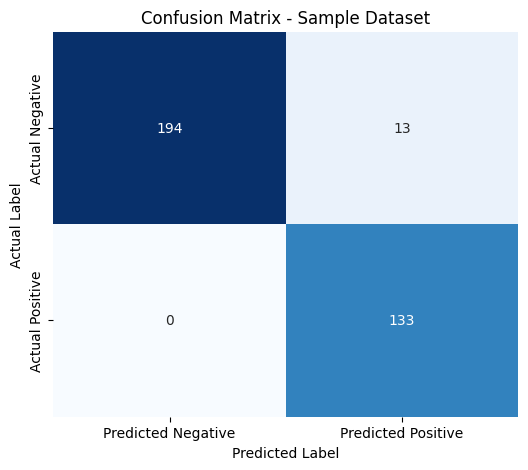


Overall Accuracy: 0.9618
Precision (Positive Class): 0.9110
Recall (Sensitivity - Positive Class): 1.0000
F1 Score (Positive Class): 0.9534

--- Additional Notes ---
Interpretation of labels for confusion matrix context:
- 'TP': Correct Positive (e.g., Grassland predicted as Grassland)
- 'TN': Correct Negative (e.g., Not Grassland predicted as Not Grassland)
- 'FP': Incorrect Positive (e.g., Not Grassland predicted as Grassland)
- 'FN': Incorrect Negative (e.g., Grassland predicted as Not Grassland)


In [20]:
# Function to calculate confusion matrix and classification metrics

def analyze_labels(df, title_suffix="Sample Dataset"):
    uncertain_count = (df['user_label'] == 'uncertain').sum()
    total_labels = len(df)
    percentage_uncertain = (uncertain_count / total_labels) * 100

    print(f"\n=== Analysis: {title_suffix} ===")
    print(f"Total labels: {total_labels}")
    print(f"Uncertain labels: {uncertain_count}")
    print(f"Percentage of uncertain labels: {percentage_uncertain:.2f}%")

    print("\n--- Metrics for Certain Labels (TP, TN, FP, FN) ---")
    certain_labels_df = df[df['user_label'] != 'uncertain'].copy()


    if len(certain_labels_df) == 0:
        print("No certain labels found for metric calculation.")
    else:
        tp = (certain_labels_df['user_label'] == 'TP (for the point location, EUGW: grassland, Aerial image: grassland)').sum() 
        tn = (certain_labels_df['user_label'] == 'TN (for the point location, EUGW: no grassland, Aerial image: no grassland)').sum() 
        fp = (certain_labels_df['user_label'] == 'FP (for the point location, EUGW: grassland, Aerial image: no grassland)').sum() 
        fn = (certain_labels_df['user_label'] == 'FN (for the point location, EUGW: no grassland, Aerial image: grassland)').sum()

        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"Total certain labels: {len(certain_labels_df)}")

        # Confusion Matrix
        conf_matrix_array = np.array([[tn, fp], [fn, tp]])

        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_array, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        plt.title(f'Confusion Matrix - {title_suffix}')
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        plt.savefig("confusion matrix.png")
        plt.show()

        # Metrics
        overall_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
        print(f"Precision (Positive Class): {precision:.4f}")
        print(f"Recall (Sensitivity - Positive Class): {recall:.4f}")
        print(f"F1 Score (Positive Class): {f1:.4f}")

        print("\n--- Additional Notes ---")
        print("Interpretation of labels for confusion matrix context:")
        print("- 'TP': Correct Positive (e.g., Grassland predicted as Grassland)")
        print("- 'TN': Correct Negative (e.g., Not Grassland predicted as Not Grassland)")
        print("- 'FP': Incorrect Positive (e.g., Not Grassland predicted as Grassland)")
        print("- 'FN': Incorrect Negative (e.g., Grassland predicted as Not Grassland)")

# Full dataset
analyze_labels(labels_grid, title_suffix="Sample Dataset")




=== Corrected Analysis: Sample Dataset with Corrected Proportions ===
Total labels: 400
Uncertain labels: 60
Percentage of uncertain labels: 15.00%

--- Metrics for Certain Labels (TP, TN, FP, FN) ---
Corrected True Positives (TP): 114.16366806753076
Corrected True Negatives (TN): 221.47555184134612
Corrected False Positives (FP): 11.158854773518044
Corrected False Negatives (FN): 0.0
Total certain labels: 340


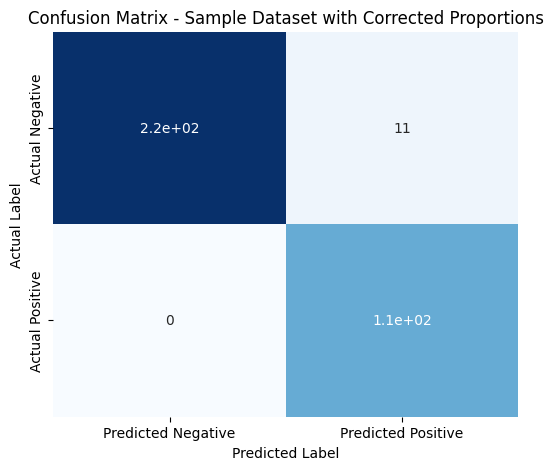


Corrected Overall Accuracy: 0.9678
Corrected Precision (Positive Class): 0.9110
Corrected Recall (Sensitivity - Positive Class): 1.0000
Corrected F1 Score (Positive Class): 0.9534

--- Additional Notes ---
Interpretation of labels for confusion matrix context:
- 'TP': Correct Positive (e.g., Grassland predicted as Grassland)
- 'TN': Correct Negative (e.g., Not Grassland predicted as Not Grassland)
- 'FP': Incorrect Positive (e.g., Not Grassland predicted as Grassland)
- 'FN': Incorrect Negative (e.g., Grassland predicted as Not Grassland)


In [21]:
# Function to calculate confusion matrix and classification metrics

AP_NG = proportions[0]
AP_G = proportions[1]

SP_NG = proportions2[0]
SP_G = proportions2[1]


def analyze_labels_corrected(df, title_suffix="Sample Dataset with Corrected Proportions"):
    uncertain_count = (df['user_label'] == 'uncertain').sum()
    total_labels = len(df)
    percentage_uncertain = (uncertain_count / total_labels) * 100

    print(f"\n=== Corrected Analysis: {title_suffix} ===")
    print(f"Total labels: {total_labels}")
    print(f"Uncertain labels: {uncertain_count}")
    print(f"Percentage of uncertain labels: {percentage_uncertain:.2f}%")

    print("\n--- Metrics for Certain Labels (TP, TN, FP, FN) ---")
    certain_labels_df = df[df['user_label'] != 'uncertain'].copy()

    if len(certain_labels_df) == 0:
        print("No certain labels found for metric calculation.")
    else:
        tp = (certain_labels_df['user_label'] == 'TP (for the point location, EUGW: grassland, Aerial image: grassland)').sum() * AP_G/SP_G
        tn = (certain_labels_df['user_label'] == 'TN (for the point location, EUGW: no grassland, Aerial image: no grassland)').sum() * AP_NG/SP_NG
        fp = (certain_labels_df['user_label'] == 'FP (for the point location, EUGW: grassland, Aerial image: no grassland)').sum() * AP_G/SP_G
        fn = (certain_labels_df['user_label'] == 'FN (for the point location, EUGW: no grassland, Aerial image: grassland)').sum() * AP_NG/SP_NG


        print(f"Corrected True Positives (TP): {tp}")
        print(f"Corrected True Negatives (TN): {tn}")
        print(f"Corrected False Positives (FP): {fp}")
        print(f"Corrected False Negatives (FN): {fn}")
        print(f"Total certain labels: {len(certain_labels_df)}")

        # Confusion Matrix
        conf_matrix_array = np.array([[tn, fp], [fn, tp]])

        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_array, annot=True, cmap='Blues', cbar=False,
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        plt.title(f'Confusion Matrix - {title_suffix}')
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        plt.savefig("corrected confusion matrix.png")
        plt.show()

        # Metrics
        overall_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\nCorrected Overall Accuracy: {overall_accuracy:.4f}")
        print(f"Corrected Precision (Positive Class): {precision:.4f}")
        print(f"Corrected Recall (Sensitivity - Positive Class): {recall:.4f}")
        print(f"Corrected F1 Score (Positive Class): {f1:.4f}")

        print("\n--- Additional Notes ---")
        print("Interpretation of labels for confusion matrix context:")
        print("- 'TP': Correct Positive (e.g., Grassland predicted as Grassland)")
        print("- 'TN': Correct Negative (e.g., Not Grassland predicted as Not Grassland)")
        print("- 'FP': Incorrect Positive (e.g., Not Grassland predicted as Grassland)")
        print("- 'FN': Incorrect Negative (e.g., Grassland predicted as Not Grassland)")

# Full dataset
analyze_labels_corrected(labels_grid, title_suffix="Sample Dataset with Corrected Proportions")

